# Long-term encoding

### Set-up

In [1]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)


################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 30 # number of epochs each sentence is presented to the model.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 1 # factor dampening connectivity amongst role neurons.

k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.
epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 

k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.
epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 2 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 4.5 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

# also note that seed will not have an effect on recall unless noise is added to the network.
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

### Simulation 13: Pivot Grammar for long-term word-to-role encoding

In the first part of long-term knowledge acquisition, we make use of pivot grammar to acquire long-term encodings for word-to-role encodings.

In [2]:
# the pivot_grammar flag switches on long-term acquisition between word and role neurons. 
# Encoding within roles layer is switched off.
pivot_grammar = True 
LT_wc_knowledge = [] # no long-term encoding
LT_cc_knowledge = [] # no long-term encoding
long_term_learning = True # switches off short-term synaptic plasticity

lambda_cc = 50/1000 
lambda_cf = 1/1000 

sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=1, role=1)) # the role neuron is activated simultaneously with the word neuron
for n in range(num_steps): sentence.append(cjn.in_in(word=2, role=2))
for n in range(tail): sentence.append(cjn.in_in())


## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       pivot_grammar = pivot_grammar,
                       long_term_learning = long_term_learning  
                      )


# running the 30 epochs of long-term acquisition
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  121
********************
Epoch = 2
Number of recorded time steps:  242
********************
Epoch = 3
Number of recorded time steps:  363
********************
Epoch = 4
Number of recorded time steps:  484
********************
Epoch = 5
Number of recorded time steps:  605
********************
Epoch = 6
Number of recorded time steps:  726
********************
Epoch = 7
Number of recorded time steps:  847
********************
Epoch = 8
Number of recorded time steps:  968
********************
Epoch = 9
Number of recorded time steps:  1089
********************
Epoch = 10
Number of recorded time steps:  1210
********************
********************
Epoch = 11
Number of recorded time steps:  1331
********************
Epoch = 12
Number of recorded time steps:  1452
********************
Epoch = 13
Number of recorded time steps:  1573
********************
Epoch = 14
Number of recorded time steps:  1694
********************
Epoch = 1

### Visualisation of long-term encoding

We can visualise the gradual learning of long-term semantic knowledge.

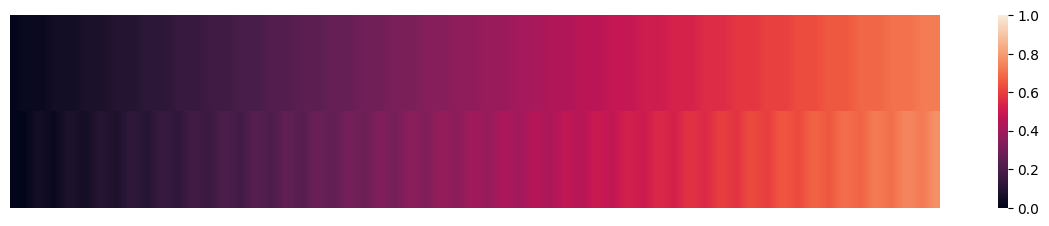

In [3]:
connections_to_track = [[1,1],[2,2]] # tracking word to role connections

cjn.long_term_encoding_plot(wc_long_weights_hx,connections_to_track)  

### Simulation 14: Long-term acquisition of syntactic structure

Next, the model is presented with random sentences of the same syntax. <br>
The model is expected to picture long-term syntactic knowledge after seeing these sentences.

In [4]:
pivot_grammar = False # switch off pivot grammar from before

LT_wc_knowledge = [[0,0],[3,1],[6,2],[9,3],[12,4],
                   [1,0],[4,1],[7,2],[10,3],[13,4],
                   [2,0],[5,1],[8,2],[11,3],[14,4],
                  ] # for each role, there are three possible words
LT_cc_knowledge = [] # no long-term c-c encoding
long_term_learning = True
lambda_cc = 50/40 
lambda_cf = 1/40 
no_periods = 1 # number of epochs is set to 1, because we change the sentence after each epoch

## we need to randomly generate the sentences to input
sentence_index = np.random.randint(3, size=(5, 30)) # 30 sentences of 5 words each
collection_of_sentences = []
for j in range(30):
    sentence = []
    for n in range(head): sentence.append(cjn.in_in())
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[0,j]))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[1,j]+3))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[2,j]+6))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[3,j]+9))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[4,j]+12))
    for n in range(tail): sentence.append(cjn.in_in())
    collection_of_sentences.append(sentence)
    
## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       pivot_grammar = pivot_grammar,
                       long_term_learning = long_term_learning  
                      )

# present each of the 30 randomly generated sentences to the network, sequentially, without reset between each epoch.
cc_long_weights_hx_collection = []
for n in range(30):
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=collection_of_sentences[n])
    cc_long_weights_hx_collection.append(cc_long_weights_hx)
cc_long_weights_hx_collection = np.asarray(cc_long_weights_hx_collection)
cc_long_weights_hx_collection = cc_long_weights_hx_collection.reshape(-1,10,10)

********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
N

### Visualisation of long-term encoding

We can visualise the gradual learning of long-term syntactic knowledge.

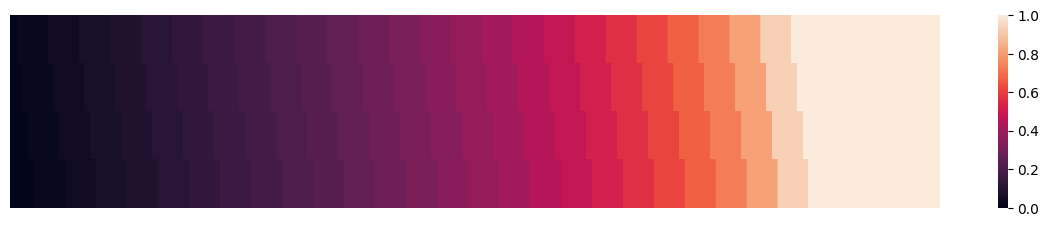

In [5]:
connections_to_track = [[0,1],[1,2],[2,3],[3,4]] # tracking role to role connections

cjn.long_term_encoding_plot(cc_long_weights_hx_collection,connections_to_track)  

### Calculating recall accuracy of model after each epoch

In [38]:
# # Long term c-c learning
# from itertools import groupby
# import pickle

# total_outcome = np.zeros((30,50))

# sentence_collection = np.zeros((30,5))

# for long_learn_epoch in range(30):
    
#     no_periods = 1
#     num_steps = 50 # number of time steps taken by each word input.
#     head = 1 # number of time steps buffering the front of each sentence.
#     tail = 20 # number of time steps buffering the end of each sentence.

    
#     seed_ = long_learn_epoch
#     np.random.seed(seed_)
#     random.seed(seed_)
    
#     unified_noise = 0
#     cc_noise = False
#     wc_noise = False
#     long_term_learning = True
#     pivot_grammar = False # switch off pivot grammar from before

#     LT_wc_knowledge = [[0,0],[3,1],[6,2],[9,3],[12,4],
#                        [1,0],[4,1],[7,2],[10,3],[13,4],
#                        [2,0],[5,1],[8,2],[11,3],[14,4],
#                       ] # for each role, there are three possible words
#     LT_cc_knowledge = [] # no long-term c-c encoding
#     long_term_learning = True
#     lambda_cc = 50/40 
#     lambda_cf = 1/40 
#     no_periods = 1 # number of epochs is set to 1, because we change the sentence after each epoch
    
#     one_w = 0+random.randint(0, 2)
#     sentence_collection[long_learn_epoch,0] = one_w
#     two_w = 3+random.randint(0, 2)
#     sentence_collection[long_learn_epoch,1] = two_w
#     three_w = 6+random.randint(0, 2)
#     sentence_collection[long_learn_epoch,2] = three_w
#     four_w = 9+random.randint(0, 2)
#     sentence_collection[long_learn_epoch,3] = four_w
#     five_w = 12+random.randint(0, 2)
#     sentence_collection[long_learn_epoch,4] = five_w
        
#     sentence = []
#     for n in range(head): sentence.append(cjn.in_in())
#     for n in range(num_steps): sentence.append(cjn.in_in(word=one_w))
#     for n in range(num_steps): sentence.append(cjn.in_in(word=two_w))
#     for n in range(num_steps): sentence.append(cjn.in_in(word=three_w))
#     for n in range(num_steps): sentence.append(cjn.in_in(word=four_w))
#     for n in range(num_steps): sentence.append(cjn.in_in(word=five_w))
#     for n in range(tail): sentence.append(cjn.in_in())
    
#     if long_learn_epoch == 0:
#         WM = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                                cc_connectivity_factor = gamma,
#                                activation_decay = beta,
#                                LR_c = lambda_cc,
#                                LR_w = lambda_cf,
#                                cc_max_connection = epsilon_cc,
#                                cf_max_connection = epsilon_cf,
#                                n_word_neurons = n_word_neurons,
#                                time_factor = tau,
#                                LT_wc_knowledge = LT_wc_knowledge,
#                                cc_learnt_weight = k_L_cc - k_cc,
#                                cf_learnt_weight = k_L_cf - k_cf,
#                                input_node_connectivity = W_ff,
#                                LT_cc_knowledge = LT_cc_knowledge,
#                                cc_floor_weight = -k_cc, 
#                                cf_floor_weight = -k_cf,
#                                unified_noise = unified_noise,
#                                cc_noise = cc_noise,
#                                wc_noise = wc_noise,
#                                cf_conj_factor = h,
#                                mc_connectivity_factor = W_mc,
#                                mm_connectivity_factor = W_mm,
#                                pivot_grammar = pivot_grammar,
#                                long_term_learning = long_term_learning  
#                               )


#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM, time_steps=len(sentence)*no_periods, sentence=sentence)

    
#     for i in range(50):
        
#         print('#'*10)
#         print('long_learn_epoch is ' + str(long_learn_epoch))
#         print('i is ' + str(i))
        
#         seed_ = long_learn_epoch * 50 + i
#         np.random.seed(seed_)
#         random.seed(seed_)

#         sentence = []
#         for n in range(head): sentence.append(cjn.in_in())
#         for n in range(num_steps): sentence.append(cjn.in_in(word=0))
#         for n in range(num_steps): sentence.append(cjn.in_in(word=3))
#         for n in range(num_steps): sentence.append(cjn.in_in(word=6))
#         for n in range(num_steps): sentence.append(cjn.in_in(word=9))
#         for n in range(num_steps): sentence.append(cjn.in_in(word=12))
#         for n in range(tail): sentence.append(cjn.in_in())   
        
#         unified_noise = 0.5
#         cc_noise = True
#         wc_noise = True
#         long_term_learning = False
#         lambda_cc = 50 # learning rate of role to role connection
#         lambda_cf = 1 
        
        
#         WM_mini = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                        cc_connectivity_factor = gamma,
#                        activation_decay = beta,
#                        LR_c = lambda_cc,
#                        LR_w = lambda_cf,
#                        cc_max_connection = epsilon_cc,
#                        cf_max_connection = epsilon_cf,
#                        n_word_neurons = n_word_neurons,
#                        time_factor = tau,
#                        LT_wc_knowledge = LT_wc_knowledge,
#                        cc_learnt_weight = k_L_cc - k_cc,
#                        cf_learnt_weight = k_L_cf - k_cf,
#                        input_node_connectivity = W_ff,
#                        LT_cc_knowledge = LT_cc_knowledge,
#                        cc_floor_weight = -k_cc, 
#                        cf_floor_weight = -k_cf,
#                        unified_noise = unified_noise,
#                        cc_noise = cc_noise,
#                        wc_noise = wc_noise,
#                        cf_conj_factor = h,
#                        mc_connectivity_factor = W_mc,
#                        mm_connectivity_factor = W_mm,
#                        pivot_grammar = pivot_grammar,
#                        long_term_learning = long_term_learning  
#                       )
        
#         for prev_c in range(n_role_neurons):
#             for next_c in range(n_role_neurons):
#                 WM_mini.cc_conn_dict[str(prev_c)+str(next_c)].long_learnt_progress = cc_long_weights_hx[270,prev_c,next_c]
        
#         print(cc_long_weights_hx[270,0,1])
        
#         role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_mini, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_mini, time_steps=len(sentence)*no_periods, sentence=sentence)

    
      
#         WM_mini_t = deepcopy(WM_mini)
#         recall_input = []
#         initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
#         n_steps = 50 # total number of time steps taken during recall
#         for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
#         for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())
#         cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_mini_t,recall_input,n_steps=n_steps,initial_steps=initial_steps)

#         aa = cjn.spec_argmax(f_act_hx_r[4:150,:,0])
#         aa = aa.tolist()

#         bb = [i[0] for i in groupby(aa)]
        
#         print(bb)
#         print('#'*10)
        
#         accuracy_count = 0
#         for word in [[0],[3],[6],[9],[12]]:
#             if word in bb:
#                 accuracy_count += 1
                
        
#         total_outcome[long_learn_epoch,i] = accuracy_count/5 * 100
        
    
    
# pickle.dump(total_outcome, open('total_outcome.pkl', 'wb'))
# pickle.dump(sentence_collection, open('sentence_collection.pkl', 'wb'))    

    

## Simulation S7: Long term encoding of branching in role-to-role connections

In [6]:
pivot_grammar = False # switch off pivot grammar from before

LT_wc_knowledge = [[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],
                  [8,1],[9,2],[10,3],[11,4],[12,5],[13,6],[14,7]] # for each role, there are three possible words
LT_cc_knowledge = [] # no long-term c-c encoding
long_term_learning = True
lambda_cc = 50/40 
lambda_cf = 1/40 
no_periods = 1 # number of epochs is set to 1, because we change the sentence after each epoch

    
## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       pivot_grammar = pivot_grammar,
                       long_term_learning = long_term_learning  
                      )

# present each of the 30 randomly generated sentences to the network, sequentially, without reset between each epoch.
sentence_1_collection = []
sentence_2_collection = []
cc_long_weights_hx_collection = []
for n in range(30):
    seed_ = n # setting default random seed
    np.random.seed(seed_)
    random.seed(seed_)
    sentence_1 = []
    sentence_1_num = [0,1+(7*random.randint(0, 1)),2+(7*random.randint(0, 1)),3+(7*random.randint(0, 1)),4+(7*random.randint(0, 1))]
    sentence_1_collection.append(sentence_1_num)
    for n in range(head): sentence_1.append(cjn.in_in())
    for n in range(num_steps): sentence_1.append(cjn.in_in(word=sentence_1_num[0]))
    for n in range(num_steps): sentence_1.append(cjn.in_in(word=sentence_1_num[1]))
    for n in range(num_steps): sentence_1.append(cjn.in_in(word=sentence_1_num[2]))
    for n in range(num_steps): sentence_1.append(cjn.in_in(word=sentence_1_num[3]))
    for n in range(num_steps): sentence_1.append(cjn.in_in(word=sentence_1_num[4]))
    for n in range(tail): sentence_1.append(cjn.in_in())

    sentence_2 = []
    sentence_2_num = [0,1+(7*random.randint(0, 1)),5+(7*random.randint(0, 1)),6+(7*random.randint(0, 1)),7+(7*random.randint(0, 1))]
    sentence_2_collection.append(sentence_2_num)
    for n in range(head): sentence_2.append(cjn.in_in())
    for n in range(num_steps): sentence_2.append(cjn.in_in(word=sentence_2_num[0]))
    for n in range(num_steps): sentence_2.append(cjn.in_in(word=sentence_2_num[1]))
    for n in range(num_steps): sentence_2.append(cjn.in_in(word=sentence_2_num[2]))
    for n in range(num_steps): sentence_2.append(cjn.in_in(word=sentence_2_num[3]))
    for n in range(num_steps): sentence_2.append(cjn.in_in(word=sentence_2_num[4]))
    for n in range(tail): sentence_2.append(cjn.in_in())
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence_1)*no_periods, sentence=sentence_1)
    cc_long_weights_hx_collection.append(cc_long_weights_hx)
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence_2)*no_periods, sentence=sentence_2)
    cc_long_weights_hx_collection.append(cc_long_weights_hx)

    
cc_long_weights_hx_collection = np.asarray(cc_long_weights_hx_collection)
cc_long_weights_hx_collection = cc_long_weights_hx_collection.reshape(-1,10,10)


********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
N

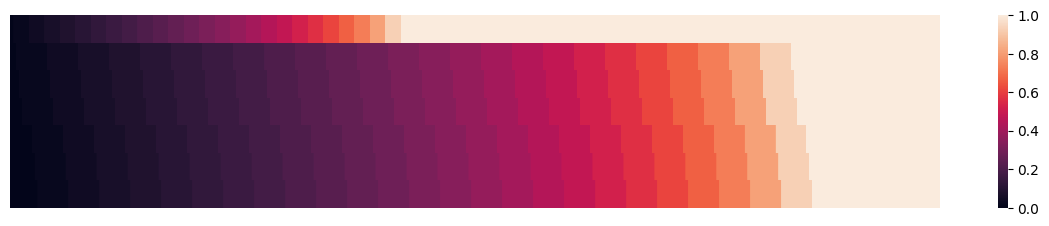

In [7]:
import matplotlib.pyplot as plt
connections_to_track = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7]] # tracking role to role connections

cjn.long_term_encoding_plot(cc_long_weights_hx_collection,connections_to_track)  
plt.savefig(fname='retrieving', transparent = True)

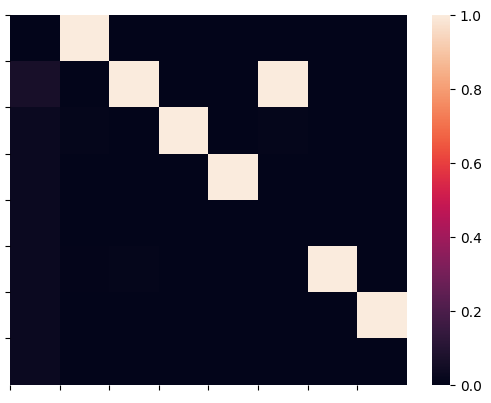

In [8]:
import seaborn as sn
ax = sn.heatmap(cc_long_weights_hx_collection[-1,:8,:8])
ax.set_xticks(ticks=range(8),labels=[])
ax.set_yticks(ticks=range(8),labels=[])
plt.savefig(fname='retrieving', transparent = True)

### Misc graphing code

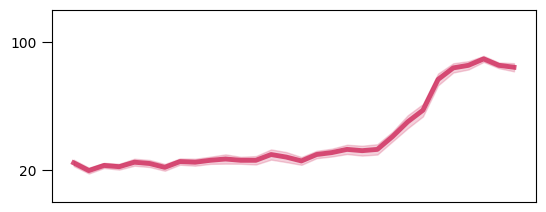

In [37]:
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
with open("total_outcome.pkl", "rb") as input_file:
    total_outcome = pickle.load(input_file)

# Creating figure for recall accuracy during Long-learning of c-c weight
final_acc_avg_ind = np.array(range(270,8131,271))
final_acc_avg = np.average(total_outcome, axis=1)
final_acc_sem = st.sem(total_outcome,axis=1)

a4_dims = (5*1.25, 2.5)
fig, ax = plt.subplots(figsize=a4_dims)

palette=sn.color_palette("rocket", 1) #7 or 5 #rocket or crest or Dark2

snsplt = sn.lineplot(x=final_acc_avg_ind,y=final_acc_avg,color=(203/255,28/255,80/255,0.75),ax=ax,linewidth = 3.5)
plt.fill_between(final_acc_avg_ind, final_acc_avg - final_acc_sem, final_acc_avg + final_acc_sem, color=(203/255,28/255,80/255,1), alpha=0.2)

ax.set(ylim=(0,120))
snsplt.set_yticks([20,100])
snsplt.tick_params(length=7.5)
# ax.set_yticklabels(['','20','100',''])
snsplt.set_xticks([])
snsplt.set(xlabel=None,ylabel=None)
# snsplt.get_legend().remove()

plt.savefig(fname='retrieving', transparent = True)

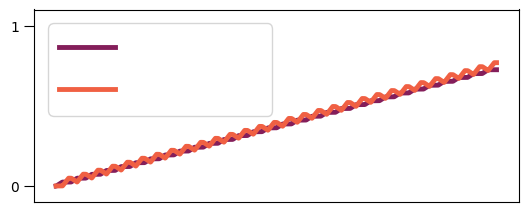

In [45]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

data_preproc1 = pd.DataFrame({
    'timesteps': np.array(range(3630)), 
    'f1<->c1': wc_long_weights_hx[:,1,1]})

data_preproc2 = pd.DataFrame({
    'timesteps': np.array(range(3630)),
    'f2<->c2': wc_long_weights_hx[:,2,2]})

# Creating figure for recall accuracy during Long-learning of c-c weight
# final_acc_avg_ind = 
# final_acc_avg = wc_long

a4_dims = (5*1.25, 2.5)
fig, ax = plt.subplots(figsize=a4_dims)

palette=sn.color_palette("rocket", 2) #7 or 5 #rocket or crest or Dark2
# sn.set_palette("rocket", 2)

snsplt = sn.lineplot(x=np.array(range(3630)),color=palette[0],y=wc_long_weights_hx[:,1,1], ax=ax,linewidth = 3.5,label='              ')
# ax.legend()
snsplt = sn.lineplot(x=np.array(range(3630)),color=palette[1],y=wc_long_weights_hx[:,2,2], ax=ax,linewidth = 3.5,label='              ')
ax.legend(loc='upper left',fontsize=20)
# plt.fill_between(final_acc_avg_ind, final_acc_avg - final_acc_sem, final_acc_avg + final_acc_sem, color=(203/255,28/255,80/255,1), alpha=0.2)


ax.set(ylim=(-0.1,1.1))
snsplt.set_yticks([0,1])
snsplt.tick_params(length=7.5)
snsplt.set_xticks([])
snsplt.set(xlabel=None,ylabel=None)


plt.savefig(fname='retrieving', transparent=True)